## Backtesting ML Regressor for Brownian Motion to give trading signals

If $\frac{max\{pred\_path\}}{\sigma} > 1\% $ then buy, and sell when price reaches $max\{pred\_path\} +- \sigma$ or sell signal is given by ...

In [2]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import alpaca_trade_api as tradeapi
import os
from dotenv import load_dotenv
from alpaca_trade_api.rest import TimeFrame
import datetime as dt_
import pytz
from time import sleep
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm
import xgboost as xgb

In [3]:
load_dotenv()
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
END_POINT = os.getenv("ALPACA_END_POINT")

In [5]:
api = tradeapi.REST(API_KEY, SECRET_KEY, END_POINT)

In [6]:
def generate_brownian_motion_params(S_t, ticker:str)->pd.DataFrame:
    time = np.array([i+1 for i in range(len(S_t)-1)])
    S = S_t[1:]
    S_lag = S_t[:-1]
    X = pd.DataFrame({'Time': time, 'S_lag': S_lag})
    X = sm.add_constant(X)
    S_m = sm.OLS(S, X).fit()
    ser = np.sqrt(S_m.mse_resid)
    bm = {
        f'{ticker}:ser': ser,
        f'{ticker}:Time': S_m.params['Time'],
        f'{ticker}:S_lag': S_m.params['S_lag'],
        f'{ticker}:Drift': S_m.params['const'],
        f'{ticker}:Drift_SE': S_m.bse['const'],
    }
    drift_t = [S[i] - time[i]*bm[f'{ticker}:Time'] - S_lag[i]*bm[f'{ticker}:S_lag'] - np.array(S_m.resid)[i] for i in range(len(S))]
    drift_resid = pd.DataFrame({"Drift": drift_t, "Resid": S_m.resid})
    drift_resid = drift_resid.corr()
    drift_resid = drift_resid.fillna(0.00001)
    bm[f'{ticker}:Drift_Resid_Corr'] = drift_resid
    return pd.DataFrame([bm])

In [7]:
def get_stocks(tickers: list[str], timeframe: str, start: str, end: str) -> pd.DataFrame:
    """
    timeframe: 1min | 5min | 15min | 1hour | 1day | 1week
    """
    stock_dfs = []
    
    for ticker in tickers:
        bars = api.get_bars(ticker, timeframe, start, end).df
        bars.reset_index(inplace=True)
        stock_df = pd.DataFrame({
            'timestamp': bars['timestamp'],
            ticker: bars['close'],
            f'{ticker}:low': bars['low'],
            f'{ticker}:high': bars['high'],
            f'{ticker}:volume': bars['volume'],
            f'{ticker}:trade_count': bars['trade_count']
        })
        stock_dfs.append(stock_df)

    merged_df = stock_dfs[0]
    
    for stock_df in stock_dfs[1:]:
        merged_df = pd.merge(merged_df, stock_df, on='timestamp', how='inner')

    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

In [8]:
model_dprice = xgb.XGBRegressor()
model_vol = xgb.XGBRegressor()
model_tc = xgb.XGBRegressor()

model_dprice.load_model('model_dprice.json')
model_vol.load_model('model_vol.json')
model_tc.load_model('model_tc.json')

In [111]:
tickers = ['AAPL','XOM']

stocks_df = get_stocks(tickers, '1hour', '2023-01-01', '2023-07-01')
df = stocks_df.copy()
df

,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,XOM:high,XOM:volume,XOM:trade_count
0,2023-01-03 09:00:00+00:00,131.30,130.2800,131.4600,143683,2513,110.77,110.61,110.960,951,19
1,2023-01-03 10:00:00+00:00,131.00,130.8000,131.4000,42853,1008,111.00,111.00,111.000,394,9
2,2023-01-03 11:00:00+00:00,130.38,130.0500,131.2500,84001,1583,110.00,110.00,110.400,1484,28
3,2023-01-03 12:00:00+00:00,130.50,130.0300,130.7500,184600,3173,109.90,109.90,110.200,16154,215
4,2023-01-03 13:00:00+00:00,130.92,129.6300,131.2285,504693,7436,109.87,109.76,110.460,37409,287
...,...,...,...,...,...,...,...,...,...,...,...
1830,2023-06-30 19:00:00+00:00,193.87,192.9000,194.4800,16366479,151351,107.21,107.18,107.765,3036387,29287
1831,2023-06-30 20:00:00+00:00,193.84,193.7500,194.0300,20305516,7112,107.04,107.00,107.250,3153680,156
1832,2023-06-30 21:00:00+00:00,193.87,193.8100,193.9700,187147,1995,107.04,107.04,107.040,1137,4
1833,2023-06-30 22:00:00+00:00,193.85,193.8100,193.9000,87210,1007,107.08,107.02,107.080,1001,3


In [112]:
for ticker in tickers:
    for i in range(1, len(df)-1):
        df.loc[df.index[i], f'{ticker}:dprice'] = 100 * (df.loc[df.index[i], ticker] / df.loc[df.index[i - 1], ticker] - 1)
        
    df = df.dropna()
    df[f'{ticker}:RSI'] = ta.rsi(df[ticker], 14)
    stoch = ta.stoch(df[f'{ticker}:high'], df[f'{ticker}:low'], df[ticker], 14)
    df[f'{ticker}:Stoch_K'] = stoch['STOCHk_14_3_3']
    df[f'{ticker}:Stoch_D'] = stoch['STOCHd_14_3_3']
    df[f'{ticker}:dEMA'] = ta.sma(df[f'{ticker}:dprice'], 14)
    df[f'{ticker}:dSMA'] = ta.ema(df[f'{ticker}:dprice'], 14)
    dBB = ta.bbands(df[f'{ticker}:dprice'], 14)
    df[f'{ticker}:dBBL'] = dBB['BBL_14_2.0']
    df[f'{ticker}:dBBM'] = dBB['BBM_14_2.0']
    df[f'{ticker}:dBBU'] = dBB['BBU_14_2.0']
    df[f'{ticker}:dBBB'] = dBB['BBB_14_2.0']
    df[f'{ticker}:dBBP'] = dBB['BBP_14_2.0']

df = df.dropna()
df.reset_index(inplace=True)
df

C:\Users\naths\AppData\Local\Temp\ipykernel_30100\2981142976.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{ticker}:RSI'] = ta.rsi(df[ticker], 14)
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\2981142976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{ticker}:Stoch_K'] = stoch['STOCHk_14_3_3']
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\2981142976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,index,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,XOM:high,...,XOM:RSI,XOM:Stoch_K,XOM:Stoch_D,XOM:dEMA,XOM:dSMA,XOM:dBBL,XOM:dBBM,XOM:dBBU,XOM:dBBB,XOM:dBBP
0,35,2023-01-05 13:00:00+00:00,126.9200,126.250,127.8700,794836,10758,106.80,106.8000,107.770,...,54.462873,82.801433,92.452696,0.047220,0.006670,-0.953532,0.047220,1.047972,4238.679711,0.054294
1,36,2023-01-05 14:00:00+00:00,127.3800,125.320,127.4891,13276667,131329,107.58,106.3001,107.630,...,62.019135,76.364652,85.452002,0.113186,0.103159,-0.936058,0.113186,1.162430,1854.018154,0.794093
2,37,2023-01-05 15:00:00+00:00,126.4200,126.160,127.7700,13624327,110524,107.75,107.1500,108.090,...,63.442943,74.034895,77.733660,0.046577,0.110474,-0.853876,0.046577,0.947030,3866.520873,0.561883
3,38,2023-01-05 16:00:00+00:00,126.6800,126.150,127.0800,8634913,71416,108.30,107.7000,108.730,...,67.666152,83.385306,77.928284,0.108055,0.163803,-0.793156,0.108055,1.009266,1668.057417,0.723247
4,39,2023-01-05 17:00:00+00:00,126.2474,126.180,126.9550,5283324,52401,109.09,108.3000,109.270,...,72.568173,88.049562,81.823255,0.164176,0.239223,-0.785664,0.164176,1.114016,1157.099208,0.797565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,1828,2023-06-30 17:00:00+00:00,193.0900,192.635,193.1200,5556002,59692,107.73,107.5400,107.740,...,74.396110,96.408519,96.188739,0.099338,0.099985,-0.324264,0.099338,0.522939,852.851159,0.519863
1794,1829,2023-06-30 18:00:00+00:00,193.0100,192.815,193.1850,5628066,59279,107.74,107.5950,107.875,...,74.492247,94.599787,95.769534,0.103779,0.087892,-0.314617,0.103779,0.522175,806.320211,0.387073
1795,1830,2023-06-30 19:00:00+00:00,193.8700,192.900,194.4800,16366479,151351,107.21,107.1800,107.765,...,61.345328,85.030777,92.013028,0.076041,0.010583,-0.434920,0.076041,0.587001,1343.914210,-0.055782
1796,1831,2023-06-30 20:00:00+00:00,193.8400,193.750,194.0300,20305516,7112,107.04,107.0000,107.250,...,57.820389,64.412689,81.347751,0.022294,-0.011971,-0.412024,0.022294,0.456611,3896.343765,0.291787


In [113]:
N = len(df)
T = 14

for ticker in tickers:
    df[f'{ticker}:signal'] = 0
    df[f'{ticker}:hold_to'] = float(0)

for n in range(14, N):
    filled_length = int(50 * n / N)
    progress = "=" * filled_length + " " * (50 - filled_length)
    print(f"\rProgress: [{progress}] {n}/{N}", end="")

    for ticker in tickers: 
        prev_path = df[n-14:n].copy()
        prev_path.reset_index(inplace=True)
        prev_path = prev_path.assign(**{f'{ticker}:price': prev_path[ticker].tolist()})
        S_0 = prev_path.iloc[-1][ticker]

        pred_path = []
        for t in range(T):
            params_model = "dprice,trade_count,volume,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP".split(",")
            params_model = [f'{ticker}:{param}' for param in params_model]

            X_features = prev_path[params_model].values 

            # Prepare X and Y with sliding windows
            X = []
            X.append(X_features[0:T])  # 14 rows of features
            X = np.array(X)
            X_flat = X.reshape(X.shape[0], -1)

            dprice = model_dprice.predict(X_flat[0].reshape(1,-1))[0] / 100

            close = (1 + dprice)*prev_path.iloc[-1][f'{ticker}:price']
            sd = np.mean(np.array(prev_path[f'{ticker}:high']) - np.array(prev_path[f'{ticker}:low'])) / 2
            high = close + sd
            low = close - sd

            pred_path.append(close)
            
            new_vol = model_vol.predict(X_flat[0].reshape(1,-1))[0]
            new_tc = model_tc.predict(X_flat[0].reshape(1,-1))[0]

            dprice = 100*(close / prev_path.iloc[-1][f'{ticker}:price'] - 1)

            new_df = {f'{ticker}:price': close, f'{ticker}:high':high, f'{ticker}:low':low, f'{ticker}:dprice': dprice, f'{ticker}:volume': new_vol, f'{ticker}:trade_count': new_tc}
            new_df = pd.DataFrame([new_df])
            cc_df = pd.concat([prev_path[f'{ticker}:price,{ticker}:low,{ticker}:high,{ticker}:dprice,{ticker}:trade_count,{ticker}:volume'.split(",")], new_df], axis=0)
            cc_df.reset_index(inplace=True)
            del cc_df['index']
            cc_df = pd.DataFrame(cc_df[-14:])

            stoch_df = cc_df.copy()

            rows_to_fill = 4
            if rows_to_fill > 0:
                empty_rows = pd.DataFrame(0, columns=stoch_df.columns, index=range(rows_to_fill))
                stoch_df = pd.concat([empty_rows, stoch_df], ignore_index=True)

            stoch = ta.stoch(
                high=stoch_df[f'{ticker}:high'],
                low=stoch_df[f'{ticker}:low'],
                close=stoch_df[f'{ticker}:price'],
                k=14
            )

            cc_df[f'{ticker}:RSI'] = ta.rsi(stoch_df[f'{ticker}:price'], 14)

            cc_df[f'{ticker}:Stoch_K'] = np.array(stoch['STOCHk_14_3_3'])[-1]
            cc_df[f'{ticker}:Stoch_D'] = np.array(stoch['STOCHd_14_3_3'])[-1]

            cc_df[f'{ticker}:dEMA'] = ta.sma(cc_df[f'{ticker}:dprice'], 14)
            cc_df[f'{ticker}:dSMA'] = ta.ema(cc_df[f'{ticker}:dprice'], 14)

            dBB = ta.bbands(cc_df[f'{ticker}:dprice'], 14)
            cc_df[f'{ticker}:dBBL'] = dBB['BBL_14_2.0']
            cc_df[f'{ticker}:dBBM'] = dBB['BBM_14_2.0']
            cc_df[f'{ticker}:dBBU'] = dBB['BBU_14_2.0']
            cc_df[f'{ticker}:dBBB'] = dBB['BBB_14_2.0']
            cc_df[f'{ticker}:dBBP'] = dBB['BBP_14_2.0']


            new_row = pd.DataFrame([cc_df.iloc[-1]])
            prev_path = pd.concat([prev_path, new_row], axis=0)[-14:]
            prev_path.reset_index(drop=True, inplace=True)
        
        returns = np.array([100*(pred_path[i] / S_0 - 1) for i in range(T)])
        mu = np.mean(returns)
        sd = np.sqrt(np.var(returns))
        mx = np.amax(returns)

        if mx > 0:
            df.loc[n, f'{ticker}:signal'] = 1 # Buy signal
            df.loc[n, f'{ticker}:hold_to'] = S_0 * (1 + mx/100 - sd/200)
        elif mx < 0:
            df.loc[n, f'{ticker}:signal'] = -1 # Sell signal


        # RETTE OPP HER!
        # q5 = np.sort(returns)[int((len(returns)-1)*0.05 + 1)]
        # q95 = np.sort(returns)[int((len(returns)-1)*0.95 + 1)]
        # if q5 > 0 and q95 > 0:
        #     df.loc[n, f'{ticker}:signal'] = 1 # Buy signal given
        #     df.loc[n, f'{ticker}:hold_to'] = S_0 * (1 + mx/100 - sd/200)

        # elif q95 > 0 and q95 > abs(q5) and mx/sd > 0.5:
        #     df.loc[n, f'{ticker}:signal'] = 1 # Buy signal given
        #     df.loc[n, f'{ticker}:hold_to'] = S_0 * (1 + mx/100 - sd/200)

        # elif q95 <= abs(q5):
        #     df.loc[n, f'{ticker}:signal'] = -1 # Sell signal given

        else:
            df.loc[n, f'{ticker}:hold_to'] = df.loc[n-1, f'{ticker}:hold_to'] # Hold



Progress: [=========                                         ] 344/1798

KeyboardInterrupt: 

In [74]:
# df = pd.read_csv('Signals.csv')

df.loc[df['AAPL:signal'] == 0] #.to_csv('Signals.csv')

,index,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,XOM:high,...,XOM:dSMA,XOM:dBBL,XOM:dBBM,XOM:dBBU,XOM:dBBB,XOM:dBBP,AAPL:signal,AAPL:hold_to,XOM:signal,XOM:hold_to
0,35,2024-11-05 12:00:00+00:00,221.5200,221.3500,222.1500,20590,753,118.790,118.6900,118.8100,...,0.099590,-0.288142,0.055698,0.399539,1234.657656,0.553787,0,0.000000,0,0.0
1,36,2024-11-05 13:00:00+00:00,221.8887,220.4000,222.1000,95348,3070,118.970,118.6400,119.0000,...,0.106515,-0.274119,0.044100,0.362319,1443.177665,0.668796,0,0.000000,0,0.0
2,37,2024-11-05 14:00:00+00:00,223.5450,221.1000,223.9500,4305414,67346,118.755,118.0100,119.4900,...,0.068217,-0.295611,0.037232,0.370076,1787.928977,0.172594,0,0.000000,0,0.0
3,38,2024-11-05 15:00:00+00:00,222.1950,222.0600,223.8452,4186117,140168,119.160,118.4714,119.2100,...,0.104593,-0.312714,0.048291,0.409296,1495.129749,0.905462,0,0.000000,0,0.0
4,39,2024-11-05 16:00:00+00:00,223.2300,221.9300,223.3300,2832608,108810,119.080,118.6900,119.1900,...,0.081696,-0.299580,0.053151,0.405882,1327.276607,0.329491,0,0.000000,0,0.0
5,40,2024-11-05 17:00:00+00:00,223.4900,223.1500,223.7800,2086581,36997,118.590,118.5700,119.1800,...,0.015938,-0.396229,0.027989,0.452208,3031.303341,-0.017984,0,0.000000,0,0.0
6,41,2024-11-05 18:00:00+00:00,222.8500,222.4002,223.5100,2258618,38045,118.350,118.0600,118.6000,...,-0.013171,-0.400479,-0.014885,0.370708,-5180.823006,0.256878,0,0.000000,0,0.0
7,42,2024-11-05 19:00:00+00:00,222.9399,222.8100,223.4500,1979377,34923,118.560,118.2600,118.6300,...,0.012244,-0.402649,-0.005222,0.392204,-15219.826527,0.729806,0,0.000000,0,0.0
8,43,2024-11-05 20:00:00+00:00,223.4600,222.7100,223.5300,4192585,62189,118.990,118.4600,119.0100,...,0.058970,-0.422150,0.018282,0.458713,4818.302895,0.890985,0,0.000000,0,0.0
9,44,2024-11-05 21:00:00+00:00,223.1766,223.0100,223.5900,5869371,2410,118.990,118.9019,118.9900,...,0.051107,-0.418033,0.021285,0.460602,4128.023832,0.475775,0,0.000000,0,0.0


In [102]:
dt = df.copy()
dt.reset_index(inplace=True)
stock_prices = df[tickers]
stock_corr = stock_prices.corr()
stock_corr

,AAPL,XOM
AAPL,1.000000,-0.790765
XOM,-0.790765,1.000000


In [103]:

for ticker in tickers:
    dt[f'{ticker}:ser'] = 0
    dt[f'{ticker}:Time'] = 0
    dt[f'{ticker}:S_lag'] = 0
    dt[f'{ticker}:Drift'] = 0
    dt[f'{ticker}:Drift_SE'] = 0
    dt[f'{ticker}:Drift_Resid_Corr'] = None
    print(f'Starting:{ticker}')
    for i in range(28, len(dt)):
        S_t = np.array(dt[ticker].to_list()[i-28:i+1])
        AR_params = generate_brownian_motion_params(S_t, ticker).iloc[0]
        dt.loc[i, AR_params.index] = AR_params

dt.dropna(inplace=True)
dt.reset_index(inplace=True, drop=True)
dt


Starting:AAPL


C:\Users\naths\AppData\Local\Temp\ipykernel_30100\1388720251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6069382746011973' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\1388720251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00238647686490312' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\1388720251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5301068521406691' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt

Starting:XOM


C:\Users\naths\AppData\Local\Temp\ipykernel_30100\1388720251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7599193297854165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\1388720251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.028672677153547044' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt.loc[i, AR_params.index] = AR_params
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\1388720251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7141515594947263' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt

,level_0,index,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,...,AAPL:S_lag,AAPL:Drift,AAPL:Drift_SE,AAPL:Drift_Resid_Corr,XOM:ser,XOM:Time,XOM:S_lag,XOM:Drift,XOM:Drift_SE,XOM:Drift_Resid_Corr
0,28,63,2024-11-07 00:00:00+00:00,222.4699,222.40,222.8125,33017,1230,121.0300,120.99,...,0.530107,104.997352,36.904855,Drift Resid Drift 1.000000 0.0...,0.759919,0.028673,0.714152,34.030732,17.028709,Drift Resid Drift 1.000000 0.1...
1,29,64,2024-11-07 09:00:00+00:00,223.3200,222.82,223.5100,21754,894,121.6400,121.63,...,0.426598,128.133605,37.063011,Drift Resid Drift 1.000000 -0.1...,0.762254,0.032976,0.704027,35.224657,16.884611,Drift Resid Drift 1.000000 0.0...
2,30,65,2024-11-07 10:00:00+00:00,223.1500,223.10,223.3400,11021,421,121.6100,121.52,...,0.523541,106.386142,38.139262,Drift Resid Drift 1.000000 -0.1...,0.760974,0.028911,0.708032,34.836137,16.856688,Drift Resid Drift 1.000000 0.3...
3,31,66,2024-11-07 11:00:00+00:00,223.0000,222.87,223.1300,15363,679,121.4200,121.41,...,0.558463,98.796268,33.849173,Drift Resid Drift 1.000000 0.4...,0.762784,0.027321,0.713801,34.172583,16.879194,Drift Resid Drift 1.000000 0.0...
4,32,67,2024-11-07 12:00:00+00:00,223.4200,222.94,223.5500,47318,1108,121.0900,121.03,...,0.592964,90.996201,35.818709,Drift Resid Drift 1.000000 0.2...,0.768088,0.020690,0.725275,32.899266,16.906716,Drift Resid Drift 1.00000 -0.1016...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,782,817,2025-01-21 18:00:00+00:00,221.2100,220.00,221.2800,6170132,95781,111.6700,111.66,...,0.845348,36.304680,21.121063,Drift Resid Drift 1.000000 -0.0...,0.273364,-0.004365,0.846081,17.319435,12.853881,Drift Resid Drift 1.000000 -0.2...
755,783,818,2025-01-21 19:00:00+00:00,221.1203,220.38,221.6900,6815931,96899,111.7550,111.36,...,0.815291,43.272326,21.869345,Drift Resid Drift 1.000000 -0.4...,0.271672,-0.004625,0.824988,19.690409,12.498078,Drift Resid Drift 1.000000 0.1...
756,784,819,2025-01-21 20:00:00+00:00,222.6600,220.31,222.7900,11108249,152301,111.5000,111.15,...,0.753258,57.617815,24.288130,Drift Resid Drift 1.000000 0.0...,0.267241,-0.008759,0.813896,20.990354,12.350787,Drift Resid Drift 1.000000 0.0...
757,785,820,2025-01-21 21:00:00+00:00,221.8988,221.68,222.7600,21617463,10380,111.5785,111.43,...,0.763758,55.019430,26.502471,Drift Resid Drift 1.000000 -0.0...,0.267553,-0.008446,0.797918,22.772493,12.593272,Drift Resid Drift 1.000000 -0.1...


In [104]:
N = 100
M = len(dt)
T = 12
t = [i+1 for i in range(T)]
dt['weights'] = 0

for i in range(M):
    filled_length = int(50 * i / M)
    progress = "=" * filled_length + " " * (50 - filled_length)
    print(f"\rProgress: [{progress}] {i}/{M}", end="")

    data = dt.loc[i]
    price_patterns = {}
    ticker_count = {ticker: 0 for ticker in tickers}
    u_t_matrix = np.random.normal(size=(N,T, len(tickers)))
    L_u = np.linalg.cholesky(stock_corr)
    for j in range(N):
        for k in range(T):
            u_t_matrix[j][k] = np.inner(L_u, u_t_matrix[j][k])

    for (q, ticker) in enumerate(tickers):
        if data[ticker + ':signal'] == 1:
            price_patterns[ticker] = np.zeros(N)
            # print(ticker)
            for j in range(N):
                S_t = [0 for _ in range(T)]
                S_t[0] = data[ticker]
                for k in range(1, T):
                    drift = np.random.normal(dt.loc[i, f'{ticker}:Drift'], 0.5*dt.loc[i, f'{ticker}:Drift_SE'])
                    u = dt.loc[i, f'{ticker}:ser']*u_t_matrix[j][k][q]
                    L = np.linalg.cholesky(dt.loc[i, f'{ticker}:Drift_Resid_Corr'])
                    dift, u_t = np.dot(L, np.array([drift, u]))
                    S_t[k] = drift + (k+i)*dt.loc[i, f'{ticker}:Time'] + S_t[k-1]*dt.loc[i, f'{ticker}:S_lag'] + u_t
                price_patterns[ticker][j] = 100*(S_t[-1] / S_t[0] - 1 )

    price_patterns = pd.DataFrame(price_patterns)
    
    price_patterns['Best_Ticker'] = price_patterns.idxmax(axis=1, skipna=True)
    counts = price_patterns['Best_Ticker'].value_counts()
    weights = {}
    for ticker in tickers:
        if ticker in counts:
            weights[ticker+':w'] = counts[ticker] / N
    weights_df = pd.DataFrame([weights]).iloc[0]
    dt.loc[i, weights_df.index] = weights_df
    

Progress: [================================================= ] 758/759

In [105]:
dt = dt.fillna(0)
dt

,level_0,index,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,...,AAPL:Drift_Resid_Corr,XOM:ser,XOM:Time,XOM:S_lag,XOM:Drift,XOM:Drift_SE,XOM:Drift_Resid_Corr,weights,AAPL:w,XOM:w
0,28,63,2024-11-07 00:00:00+00:00,222.4699,222.40,222.8125,33017,1230,121.0300,120.99,...,Drift Resid Drift 1.000000 0.0...,0.759919,0.028673,0.714152,34.030732,17.028709,Drift Resid Drift 1.000000 0.1...,0,0.35,0.65
1,29,64,2024-11-07 09:00:00+00:00,223.3200,222.82,223.5100,21754,894,121.6400,121.63,...,Drift Resid Drift 1.000000 -0.1...,0.762254,0.032976,0.704027,35.224657,16.884611,Drift Resid Drift 1.000000 0.0...,0,0.03,0.97
2,30,65,2024-11-07 10:00:00+00:00,223.1500,223.10,223.3400,11021,421,121.6100,121.52,...,Drift Resid Drift 1.000000 -0.1...,0.760974,0.028911,0.708032,34.836137,16.856688,Drift Resid Drift 1.000000 0.3...,0,0.00,1.00
3,31,66,2024-11-07 11:00:00+00:00,223.0000,222.87,223.1300,15363,679,121.4200,121.41,...,Drift Resid Drift 1.000000 0.4...,0.762784,0.027321,0.713801,34.172583,16.879194,Drift Resid Drift 1.000000 0.0...,0,0.98,0.02
4,32,67,2024-11-07 12:00:00+00:00,223.4200,222.94,223.5500,47318,1108,121.0900,121.03,...,Drift Resid Drift 1.000000 0.2...,0.768088,0.020690,0.725275,32.899266,16.906716,Drift Resid Drift 1.00000 -0.1016...,0,0.99,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,782,817,2025-01-21 18:00:00+00:00,221.2100,220.00,221.2800,6170132,95781,111.6700,111.66,...,Drift Resid Drift 1.000000 -0.0...,0.273364,-0.004365,0.846081,17.319435,12.853881,Drift Resid Drift 1.000000 -0.2...,0,0.00,1.00
755,783,818,2025-01-21 19:00:00+00:00,221.1203,220.38,221.6900,6815931,96899,111.7550,111.36,...,Drift Resid Drift 1.000000 -0.4...,0.271672,-0.004625,0.824988,19.690409,12.498078,Drift Resid Drift 1.000000 0.1...,0,0.00,1.00
756,784,819,2025-01-21 20:00:00+00:00,222.6600,220.31,222.7900,11108249,152301,111.5000,111.15,...,Drift Resid Drift 1.000000 0.0...,0.267241,-0.008759,0.813896,20.990354,12.350787,Drift Resid Drift 1.000000 0.0...,0,0.00,1.00
757,785,820,2025-01-21 21:00:00+00:00,221.8988,221.68,222.7600,21617463,10380,111.5785,111.43,...,Drift Resid Drift 1.000000 -0.0...,0.267553,-0.008446,0.797918,22.772493,12.593272,Drift Resid Drift 1.000000 -0.1...,0,0.00,1.00


## Skrive om til bruk av hold_to funksjonen for å exite når målpris er nådd

In [107]:
M = len(dt)
cash = 10000  # 10,000 USD
portfolio_value = cash
positions = {ticker: 0 for ticker in tickers}  # Fixed typo

portfolio_performance = [cash]
c = 0  # Counter for transactions

for i in range(M):
    # Uncomment for progress bar if needed
    # filled_length = int(50 * i / M)
    # progress = "=" * filled_length + " " * (50 - filled_length)
    # print(f"\rProgress: [{progress}] {i}/{M}", end="")

    data = dt.iloc[i]  # Changed to .iloc for position-based indexing
    portfolio_value = cash  # Reset to cash
    for ticker in tickers:
        portfolio_value += data[ticker] * positions[ticker]

    portfolio_performance.append(portfolio_value)

    for ticker in tickers:
        signal = data[f'{ticker}:signal']
        price = data[ticker]
        weight = data[f'{ticker}:w']
        
        # Ensure valid price
        if price <= 0:
            continue

        if (signal == 0 and price >= data[f'{ticker}:hold_to'] and positions[ticker] > 0) or (signal == -1 and positions[ticker] > 0):  # Sell logic
            cash += positions[ticker] * price
            positions[ticker] = 0
            c += 1
        elif signal == 1 and positions[ticker] == 0:  # Buy logic
            qty = cash * weight // price
            if qty > 0:
                cash -= qty * price
                positions[ticker] = qty
                c += 1

# Final portfolio value
portfolio_value = cash + sum(positions[ticker] * dt.iloc[-1][ticker] for ticker in tickers)
portfolio_performance.append(portfolio_value)

portfolio_performance
c

188

In [108]:
result_df = dt[tickers]
for ticker in tickers:
    result_df[f'{ticker}:norm'] = (result_df[ticker] / result_df.loc[0, ticker] - 1)*100

result_df['Portfolio'] = np.array(portfolio_performance)[2:]
result_df['Portfolio:norm'] = (result_df['Portfolio'] / result_df.loc[0, 'Portfolio'] - 1)*100
result_df['date'] = dt['timestamp']
result_df['date'] = pd.to_datetime(result_df['date'])

result_df

C:\Users\naths\AppData\Local\Temp\ipykernel_30100\4292405773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:norm'] = (result_df[ticker] / result_df.loc[0, ticker] - 1)*100
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\4292405773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:norm'] = (result_df[ticker] / result_df.loc[0, ticker] - 1)*100
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\4292405773.py:5: SettingWithCopyWarning: 
A value is trying to be 

,AAPL,XOM,AAPL:norm,XOM:norm,Portfolio,Portfolio:norm,date
0,222.4699,121.0300,0.000000,0.000000,10034.1015,0.000000,2024-11-07 00:00:00+00:00
1,223.3200,121.6400,0.382119,0.504007,10030.5015,-0.035878,2024-11-07 09:00:00+00:00
2,223.1500,121.6100,0.305704,0.479220,10021.6015,-0.124575,2024-11-07 10:00:00+00:00
3,223.0000,121.4200,0.238279,0.322234,10016.3515,-0.176897,2024-11-07 11:00:00+00:00
4,223.4200,121.0900,0.427069,0.049574,10027.3550,-0.067236,2024-11-07 12:00:00+00:00
...,...,...,...,...,...,...,...
754,221.2100,111.6700,-0.566324,-7.733620,10323.1572,2.880733,2025-01-21 18:00:00+00:00
755,221.1203,111.7550,-0.606644,-7.663389,10362.9538,3.277347,2025-01-21 19:00:00+00:00
756,222.6600,111.5000,0.085450,-7.874081,10342.6607,3.075105,2025-01-21 20:00:00+00:00
757,221.8988,111.5785,-0.256709,-7.809221,10362.3938,3.271766,2025-01-21 21:00:00+00:00


C:\Users\naths\AppData\Local\Temp\ipykernel_30100\2606454621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:smoothed'] = result_df[f'{ticker}:norm'].rolling(window=window_size).mean()
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\2606454621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[f'{ticker}:smoothed'] = result_df[f'{ticker}:norm'].rolling(window=window_size).mean()
C:\Users\naths\AppData\Local\Temp\ipykernel_30100\2606454621.py:14: SettingWithCopyWarning

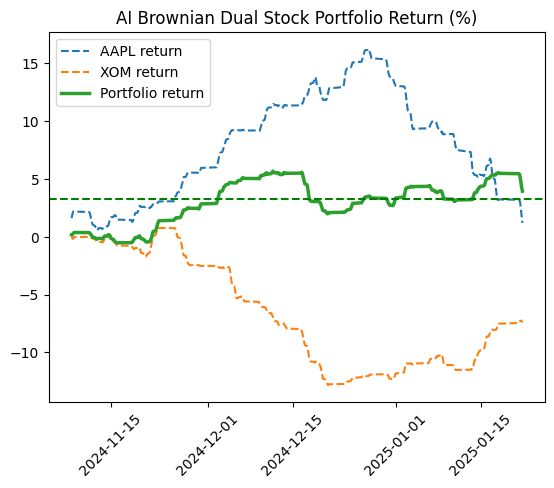

In [109]:
# for ticker in tickers:
#     plt.plot(result_df['date'], result_df[f'{ticker}:norm'], label=f'{ticker} return')

# plt.plot(result_df['date'], result_df['Portfolio:norm'], label='Portfolio return')
# plt.legend()
# plt.title('EMA-SMA 6 stock portfolio return')
# plt.show()

# Apply rolling mean for smoothing
window_size = 20  # Adjust the window size as needed
for ticker in tickers:
    result_df[f'{ticker}:smoothed'] = result_df[f'{ticker}:norm'].rolling(window=window_size).mean()

result_df['Portfolio:smoothed'] = result_df['Portfolio:norm'].rolling(window=window_size).mean()

# Plot the smoothed data
for ticker in tickers:
    plt.plot(result_df['date'], result_df[f'{ticker}:smoothed'], label=f'{ticker} return', linestyle='--')

plt.plot(result_df['date'], result_df['Portfolio:smoothed'], label='Portfolio return', linewidth=2.5)
plt.axhline(y=list(result_df['Portfolio:norm'])[-1], linestyle='--', color='green')
plt.legend()
plt.title('AI Brownian Dual Stock Portfolio Return (%)')
plt.xticks(rotation=45)
plt.show()
